#Sequence classification models for English Linguistic Acceptability

In  this  project,  we  evaluate  performances  of various deep learning architectures on a hardSequence  Classification  problem,   which  isidentifying  grammatical  acceptability  of  English sentences.


**Authors : Oscar Bouvier, Rayane Hanifi**

# Installing packages

In [ ]:
!pip install allennlp
!pip install transformers
!pip install wget

     |████████████████████████████████| 634kB 7.5MB/s 
     |████████████████████████████████| 2.1MB 14.7MB/s 
     |████████████████████████████████| 266kB 34.5MB/s 
     |████████████████████████████████| 2.1MB 43.6MB/s 
     |████████████████████████████████| 1.2MB 53.1MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 122kB 53.2MB/s 
     |████████████████████████████████| 163kB 52.5MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 133kB 52.6MB/s 
     |████████████████████████████████| 3.3MB 55.9MB/s 
     |████████████████████████████████| 901kB 55.8MB/s 
     |████████████████████████████████| 7.4MB 54.6MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
  Created wheel for jsonnet: filename=jsonnet-0.17.0-cp37-cp37m-linux_x86_64.whl size=3388870 sha256=8a82cab39cbba57ee94aec117488d9351f031ac34c9779f0fb93eac0b13efbd

Useful paper : https://arxiv.org/pdf/1805.12471v1.pdf

Github for models : https://github.com/nyu-mll/CoLA-baselines

#Loading packages

In [ ]:
from tqdm.notebook import tqdm

import os
import wget

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

from gensim.models import fasttext, word2vec

import torch
from torch import nn
from torch.nn import LSTM, Embedding
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

import transformers
from transformers import BertForSequenceClassification, BertTokenizer

from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

#Using GPU

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")

# I) Dataset analysis

We’ll use The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification. It’s a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the “GLUE Benchmark” on which models like BERT are competing.

In [ ]:
!wget 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

--2021-04-23 15:17:44--  https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
Resolving nyu-mll.github.io (nyu-mll.github.io)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to nyu-mll.github.io (nyu-mll.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255330 (249K) [application/zip]
Saving to: ‘cola_public_1.1.zip’

cola_public_1.1.zip 100%[===================>] 249.35K  --.-KB/s    in 0.02s   

2021-04-23 15:17:44 (11.9 MB/s) - ‘cola_public_1.1.zip’ saved [255330/255330]

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_p

In [ ]:
df_train = pd.read_csv("./cola_public/raw/in_domain_train.tsv", 
                 delimiter='\t', header=None, 
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

df_train.head(5)

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [ ]:
df_train_tokenized = pd.read_csv("./cola_public/tokenized/in_domain_train.tsv", 
                 delimiter='\t', header=None, 
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

We drop some of the sentences that includes sentences that can't be handle by pretrained embedding techniques.

In [ ]:
print(df_train_tokenized.sentence[3954])
df_train_tokenized.drop(3954, inplace=True)

ad agencies call young people generation x-ers .


In [ ]:
print(df_train_tokenized.sentence[7129])
df_train_tokenized.drop(7129, inplace=True)
print(df_train_tokenized.sentence[7130])
df_train_tokenized.drop(7130, inplace=True)
print(df_train_tokenized.sentence[7131])
df_train_tokenized.drop(7131, inplace=True)
print(df_train_tokenized.sentence[7132])
print(df_train_tokenized.sentence[7133])

this girl in the red coat will put a picture of bill it on your desk before tomorrow .
this girl in the red coat will put a picture of bill on your desk there before tomorrow .
this girl in the red coat one will put a picture of bill on your desk before tomorrow .
this girl in the red coat will put a picture of bill on your desk it before tomorrow .
this girl in the red coat will put a picture of bill on your desk before tomorrow .


In [ ]:
sentences_train, labels_train = df_train.sentence.to_list(), df_train.label.to_list()

***Dataset distribution***

We observe an imbalanced dataset distribution. We choose not to oversample data so as to prevent model overfitting the model on incorrect labelled sentences.



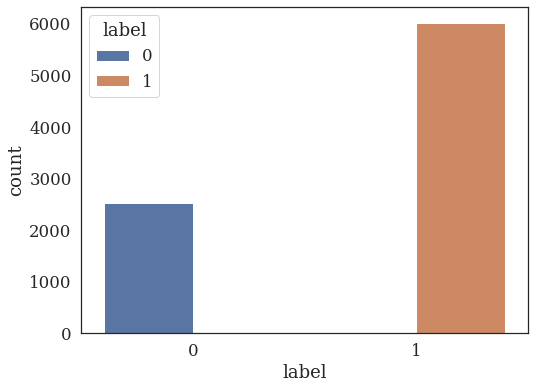

In [ ]:
sns.set(rc={'figure.figsize':(8,6)}, style='white', font_scale=1.5, font='serif')
sns.countplot(x='label', data=df_train, hue='label')
plt.show()

### Test Dataset

We observe similar distribution on In-domain test and Out-of-domain test dataset.

In [ ]:
df_test_in = pd.read_csv("./cola_public/raw/in_domain_dev.tsv", 
                    delimiter='\t', header=None, 
                    names=['sentence_source', 'label', 'label_notes', 'sentence'])

df_test_out = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", 
                    delimiter='\t', header=None, 
                    names=['sentence_source', 'label', 'label_notes', 'sentence'])

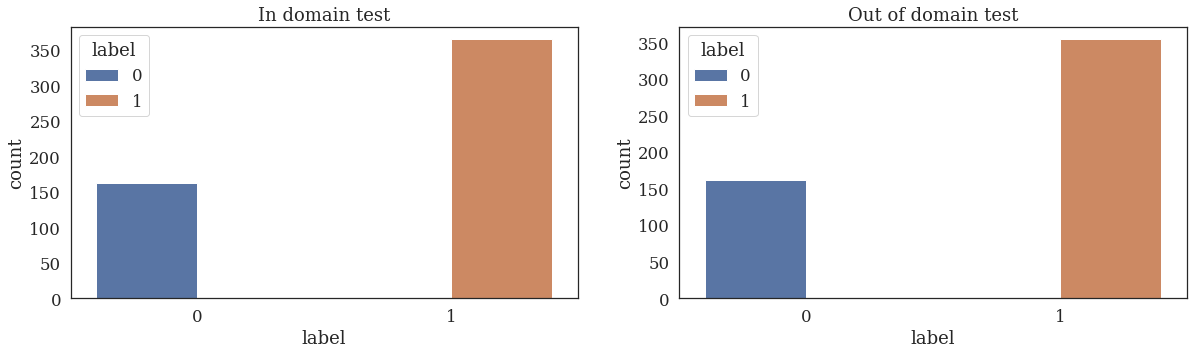

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))

sns.set(rc={'figure.figsize':(8,6)}, style='white', font_scale=1.5, font='serif')

sns.countplot(x='label', data=df_test_in, hue='label', ax=ax1)
ax1.set_title('In domain test')
sns.countplot(x='label', data=df_test_out, hue='label', ax=ax2)
ax2.set_title('Out of domain test')
plt.show()

Out-of-domain sentences seems to be more informal than the training and In-domain testing sentences.

In [ ]:
df_test_in.sentence.head(5)

0      The sailors rode the breeze clear of the rocks.
1    The weights made the rope stretch over the pul...
2           The mechanical doll wriggled itself loose.
3          If you had eaten more, you would want less.
4             As you eat the most, you want the least.
Name: sentence, dtype: object

In [ ]:
df_test_out.sentence.head(5)

0                      Somebody just left - guess who.
1    They claimed they had settled on something, bu...
2            If Sam was going, Sally would know where.
3    They're going to serve the guests something, b...
4                 She's reading. I can't imagine what.
Name: sentence, dtype: object

In [ ]:
sentences_test_in = df_test_in.sentence.to_list()
labels_test_in = df_test_in.label.to_list()

sentences_test_out = df_test_out.sentence.to_list()
labels_test_out = df_test_out.label.to_list()

# II) Preprocessing and Embeddings



In this part, we aim to build preprocessing pipeline and compute corpus embeddings for LSTM classifier. We will use three word embedding techniques to study their influence : word2vec, FastText and pretrained Glove (to compete fairly against other pretrained embedding techniques).

FastText is an algorithm developed by Facebook Research, designed to extend word2vec (word embedding) to use n-grams.  An n-gram represents N words prior to the current word to create a single phrase. This provides context to the input similar to the way the RNN interprets the time series aspect and the CNN encodes the spatial aspect of the data

## A) Preprocessing

We use Treewordbank tokenizer to separate all the contractions and punctuations considered as unique tokens in the sentence.

In [ ]:
tokenizer = TreebankWordTokenizer()

def tokenize_sentence(sentences, tokenizer):
  tokenized_sentences = []
  for sentence in sentences:
    tokens = tokenizer.tokenize(sentence)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokenized_sentences.append(tokens)

  return tokenized_sentences

corpus = sentences_train + sentences_test_in + sentences_test_out

tokenized_corpus = tokenize_sentence(corpus, tokenizer)

We need to now the average number of words per sentence to know how many grams we will use in our models

In [ ]:
list_count=[]
for l in tokenized_corpus:
    list_count.append(len(l))

avg=np.mean(list_count)
avg

8.918594955180321

In [ ]:
import itertools

print("Number of words in corpus : ", len(list(itertools.chain(*tokenized_corpus))))

Number of words in corpus :  85565


In [ ]:
print("Number of unique words in corpus : ", len(set(list(itertools.chain(*tokenized_corpus)))))

Number of unique words in corpus :  5718


## B) Embeddings

### Training Word2vec and FastText embeddings on corpus

We have preprocessed our corpus. Now is the time to create word representations using FastText and Word2Vec.

In [ ]:
fasttext_model = fasttext.FastText(sentences=tokenized_corpus, window=3, min_count=1, word_ngrams=2, iter=100)
word2vec_model = word2vec.Word2Vec(sentences=tokenized_corpus, window=3, min_count=1, iter=100)

Example of most similar embeddings for "get" : it seems that the two embedding models close "get" to other verb which is consistent in the case of our study. FastText has also best-ranked words with similar n-grams ('budget', 'gourmet').

In [ ]:
print('Word2vec : ', word2vec_model.similar_by_word('get'))
print('Fast Text : ', fasttext_model.wv.similar_by_word('get'))

Word2vec :  [('make', 0.581061840057373), ('arrive', 0.5040568709373474), ('study', 0.5033581256866455), ('incriminate', 0.4907127916812897), ('buy', 0.4609854221343994), ('come', 0.45177534222602844), ('meet', 0.4396987557411194), ('leave', 0.43767082691192627), ('find', 0.4376031458377838), ('build', 0.4358161687850952)]
Fast Text :  [('budget', 0.6510941982269287), ('set', 0.5647508502006531), ('gourmet', 0.5430889129638672), ('serve', 0.533201277256012), ('go', 0.5153351426124573), ('gets', 0.5007809400558472), ('meet', 0.5006760358810425), ('task', 0.4741944968700409), ('omelet', 0.46800893545150757), ('see', 0.4606482684612274)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


Example of most similar embeddings for 'car' : it seems once that the two embedding models are consistant since they close "car" to other nouns as well. FastText has also best-ranked words with similar n-grams which is not very consistent in this example.

In [ ]:
print('Word2vec : ', word2vec_model.similar_by_word('car'))
print('Fast Text : ', fasttext_model.wv.similar_by_word('car'))

Word2vec :  [('bicycle', 0.43036550283432007), ('ball', 0.407338947057724), ('snake', 0.4065490961074829), ('house', 0.39629197120666504), ('refrigerator', 0.391060471534729), ('vase', 0.3884238600730896), ('package', 0.3879668712615967), ('tax', 0.3801015615463257), ('contacts', 0.3799455463886261), ('dimple', 0.3747917413711548)]
Fast Text :  [('carpet', 0.851919412612915), ('card', 0.849084734916687), ('carthage', 0.8256552219390869), ('cart', 0.8228402137756348), ('carriage', 0.8159146308898926), ('carrot', 0.8113024830818176), ('cards', 0.7912584543228149), ('carrots', 0.7878397703170776), ('oscar', 0.7864748239517212), ('carts', 0.7620292901992798)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


### Loading pretrained GloVe embeddings

Here we load pretrained GloVe 100-d embeddings trained on wikipedia database.

In [ ]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
glove_model = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
glove_model.most_similar('get')

[('getting', 0.8922716975212097),
 ("n't", 0.8879422545433044),
 ('you', 0.887437641620636),
 ('want', 0.8848960399627686),
 ('go', 0.8843335509300232),
 ('got', 0.8842746019363403),
 ('going', 0.8716604709625244),
 ("'ll", 0.870947539806366),
 ('come', 0.8707302212715149),
 ("'d", 0.8563904166221619)]

In [ ]:
glove_model.most_similar('car')

[('vehicle', 0.8630838394165039),
 ('truck', 0.8597878217697144),
 ('cars', 0.837166965007782),
 ('driver', 0.8185911178588867),
 ('driving', 0.7812635898590088),
 ('motorcycle', 0.7553156614303589),
 ('vehicles', 0.7462256550788879),
 ('parked', 0.7459464073181152),
 ('bus', 0.737270712852478),
 ('taxi', 0.7155268788337708)]

We can see that GloVe embeddings are much more consistent and that the vocabulary is huge.

In [ ]:
def encode_tokenized_sentence(tokenized_sentence, model):
  tokens_id_list = []
  for token in tokenized_sentence:
    tokens_id_list.append(model.wv.vocab.get(token).index)

  return tokens_id_list

def encode_sentences(tokenized_sentences, model):

  token_id_sentences = []
  for i, tokenized_sentence in enumerate(tokenized_sentences):
    token_id_sentences.append(torch.LongTensor(encode_tokenized_sentence(tokenized_sentence, model)))

  input_id_sentences = pad_sequence(token_id_sentences, batch_first=True, padding_value=0)

  return input_id_sentences

### Saving embedding weights

In [ ]:
weights_fasttext = torch.FloatTensor(fasttext_model.wv.vectors)
weights_word2vec = torch.FloatTensor(word2vec_model.wv.vectors)
weights_glove = torch.FloatTensor(glove_model.wv.vectors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


# 3) Models

We build three models to perform classifier : LSTM, ELMO, and BERT.

## A) LSTM Classifier

In [ ]:
class LSTM_classifier(nn.Module):

  def __init__(self, label_size, vocab_size, embedding_dim, hidden_dim, num_layers=2,
               bidirectional = True, dropout=0.2, from_pretrained = False, weights = None):
    super(LSTM_classifier, self).__init__()

    if from_pretrained:
      self.word_embeddings = nn.Embedding.from_pretrained(weights)
      
    else:
      self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

    self.dropout = dropout
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, dropout = dropout, bidirectional=bidirectional)
    
    self.output_layer = nn.Linear((1 + int(bidirectional)) * hidden_dim, label_size)
  
  def forward(self, id_sequence):
    embedded_sequence = self.word_embeddings(id_sequence)
    out,_ = self.lstm(embeddings)
    x = out[:, -1, :] #many to 1 architecture
    x = self.output_layer(x)

    return F.softmax(x, dim=0)


class LSTM_Pooling_Classifier(nn.Module):
  
  def __init__(self, label_size, vocab_size, embedding_dim, hidden_dim, num_layers=2,
                 bidirectional=True, dropout=0.5, from_pretrained = False, weights = None):
    super(LSTM_Pooling_Classifier, self).__init__()

    self.embedding = nn.Embedding.from_pretrained(weights)
    self.hidden_dim = hidden_dim
    self.embedding_size = embedding_dim
    
    if from_pretrained:
      self.word_embeddings = nn.Embedding.from_pretrained(weights)
      
    else:
      self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    
    self.num_layers = num_layers
    self.dropout = nn.Dropout(p=dropout)
      
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                        bidirectional=bidirectional, batch_first=True, dropout=dropout)
    
    self.pooling = nn.Linear((1 +int(bidirectional)) * hidden_dim, label_size)

  def forward(self, x):

    embedded_sequence = self.embedding(x)
    out, _ = self.lstm(embedded_sequence)
    pool = nn.functional.max_pool1d(out.transpose(1, 2), x.shape[1])
    pool = pool.transpose(1, 2).squeeze()
    pool = self.dropout(pool)
    output = F.softmax(self.pooling(pool), dim=1)
      
    return output.squeeze()

## B) ELMO Classifier

Loading pretrained ELMO embeddings 

In [ ]:
!wget https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json
!wget https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5

--2021-04-23 15:41:48--  https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.153.128
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 336 [application/json]
Saving to: ‘elmo_2x4096_512_2048cnn_2xhighway_options.json’

elmo_2x4096_512_204 100%[===================>]     336  --.-KB/s    in 0s      

2021-04-23 15:41:48 (11.7 MB/s) - ‘elmo_2x4096_512_2048cnn_2xhighway_options.json’ saved [336/336]

--2021-04-23 15:41:48--  https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.153.128
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.153.128|:443... c

In [ ]:
from allennlp.modules.elmo import Elmo, batch_to_ids

class ELMOPoolingClassifier(nn.Module):
    def __init__(self, label_size, dropout=0.5):
        super(ELMOPoolingClassifier, self).__init__()
        self.dropout = dropout

        options_file = "elmo_2x4096_512_2048cnn_2xhighway_options.json"
        weight_file = "elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

        self.elmo = Elmo(options_file, weight_file, 1, dropout=dropout, do_layer_norm=False)

        #Shape : (batch, 1024, max_batch_len)
        self.conv = nn.Conv1d(1024, 16, 3)
        self.pooling = nn.AdaptiveMaxPool1d(128)
        self.dropout_l = nn.Dropout(dropout)
        self.fc = nn.Linear(2048, label_size)

    def forward(self, id_sequences):
        elmo_out = self.elmo(id_sequences)
        x = elmo_out['elmo_representations'][0]
        x = x.transpose(1,2)
        x = self.conv(x)
        x = F.relu(x)
        x = self.pooling(x)
        #Flattening vector
        x = x.view(-1, 2048)
        x = nn.Dropout(self.dropout)(x)
        y = F.softmax(self.fc(x), dim=1)

        return y

## C) Pretrained Bert Classifier

Loading pretrained Bert Classifier

In [ ]:
bert_clf = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2, output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# 4) Experiments

## Training and testing functions

Here, we define training and testing functions wich are consistent for every classifier.

In [ ]:
def train(model, train_loader, val_loader, lr=5e-5, n_epochs=10):

  model.to(device)

  optimizer = Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  loss_history = []

  for epoch in range(n_epochs):

    print(f'Epoch {epoch} ...')
    total_loss = 0

    for step, batch in enumerate(train_loader):

      model.zero_grad()

      #BERT case : (input, attention_mask, label)
      if len(batch) == 3:
        batch_input = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_label = batch[2].to(device)

        output = model(batch_input, attention_mask = batch_attention_mask)[0]
      
      #LSTM and ELMO case : (input, label)
      else:
        batch_input = batch[0].to(device)
        batch_label = batch[1].to(device)

        output = model(batch_input)

      output.to(device)

      #Compute loss during training
      loss = criterion(output, batch_label)

      total_loss += loss.item()
      batch_label_pred = torch.argmax(output, axis = 1).to('cpu').numpy()
      batch_true_label = batch_label.to('cpu').numpy()
      
      #Gradient descent step
      loss.backward()

      nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()

    avg_train_loss = total_loss / len(train_loader) 
    loss_history.append(loss.item())

    if epoch%1==0:
      #Compute accuracy on validation set after each epoch
      true_labels = []
      pred_labels = []

      for step_val, batch_val in (enumerate(val_loader)):

        with torch.no_grad():
          
          #BERT case
          if len(batch) == 3:
            batch_input_val = batch_val[0].to(device)
            batch_attention_masks_val = batch_val[1].to(device)
            batch_labels_val = batch_val[2].to(device)

            output = model(batch_input_val, attention_mask = batch_attention_masks_val)[0]

          #LSTM and ELMO case
          else:
            batch_input_val = batch_val[0].to(device)
            batch_labels_val = batch_val[1].to(device)

            output = model(batch_input_val)

          val_label_pred = torch.argmax(output, axis = 1).to('cpu').numpy().tolist()
          val_true_label = batch_labels_val.to('cpu').numpy().tolist()

          true_labels += val_true_label
          pred_labels += val_label_pred
          
      accuracy = accuracy_score(true_labels, pred_labels)
      precision, recall, f_score, _ = precision_recall_fscore_support(true_labels, pred_labels, labels=[0, 1])
      mcc = matthews_corrcoef(true_labels, pred_labels)

      print(f'Accuracy at epoch {epoch + 1} :  {accuracy}')
      print(f'F0 score at epoch {epoch + 1} : {f_score[0]}')
      print(f'F1 score at epoch {epoch + 1} : {f_score[1]}')
      print(f'Mattthews Correlation Coeffient at epoch {epoch + 1} :  {mcc}')
  
  sns.set(rc={'figure.figsize':(8,6)}, style='white', font_scale=1.5, font='serif')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(loss_history, 'b-o')

  plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

def test(model, test_loader):
  true_labels = []
  pred_labels = []
  logits_pred = []

  model.eval()
  model.to(device)

  for batch in test_loader:
    
    with torch.no_grad():
      
      #BERT case
      if len(batch) == 3:
          batch_input = batch[0].to(device)
          batch_attention_mask = batch[1].to(device)
          batch_label = batch[2].to(device)

          output = model(batch_input, attention_mask = batch_attention_mask)[0]
      
      #LSTM and ELMO case
      else:
        batch_input = batch[0].to(device)
        batch_label = batch[1].to(device)

        output = model(batch_input)
      
      label_pred = torch.argmax(output, axis=1).to('cpu').numpy()

      true_label = batch_label.to('cpu').numpy()
      logits_pred.append(output.to('cpu').numpy())

      accuracy = accuracy_score(true_label, label_pred)
      precision, recall, f_score, _ = precision_recall_fscore_support(true_label, label_pred, labels=[0, 1])
      mcc = matthews_corrcoef(true_label, label_pred)
      conf_matrix = confusion_matrix(true_label, label_pred)

  print(f'Accuracy on test :  {accuracy}')
  print(f'F0 score on test : {f_score[0]}')
  print(f'F1 score on test : {f_score[1]}')
  print(f'Mattthews Correlation Coeffient on test :  {mcc}')
  print(f'Confusion matrix : {conf_matrix}')

## A) LSTM Analysis

***Choice of the embedding model***

Since in the following experiments, we observe no changes with the choice embedding model, we chose here FastText embeddings.

In [ ]:
embedding_model = fasttext_model
weights = weights_fasttext

***Defining train and validation loader***

In [ ]:
batch_size = 32
sampler_seed = 0

tokenized_sentences_train = tokenize_sentence(sentences_train, tokenizer)
tokens_id_train = encode_sentences(tokenized_sentences_train, embedding_model)

input_train, input_val, labels_training, labels_val = train_test_split(tokens_id_train, labels_train, test_size=0.2, random_state=sampler_seed)

input_train = torch.tensor(input_train)
labels_training = torch.tensor(labels_training)

train_dataset = TensorDataset(input_train, labels_training)
train_loader = DataLoader(train_dataset, batch_size = batch_size)

input_val = torch.tensor(input_val)
labels_val = torch.tensor(labels_val)

val_dataset = TensorDataset(input_val, labels_val)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


***Training***

LSTM network : 5 layers, 128 units per layer.

Epoch 0 ...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Accuracy at epoch 1 :  0.7025131502045587
F0 score at epoch 1 : 0.0
F1 score at epoch 1 : 0.8252660487469963
Mattthews Correlation Coeffient at epoch 1 :  0.0
Epoch 1 ...
Accuracy at epoch 2 :  0.7025131502045587
F0 score at epoch 2 : 0.0
F1 score at epoch 2 : 0.8252660487469963
Mattthews Correlation Coeffient at epoch 2 :  0.0
Epoch 2 ...
Accuracy at epoch 3 :  0.7025131502045587
F0 score at epoch 3 : 0.0
F1 score at epoch 3 : 0.8252660487469963
Mattthews Correlation Coeffient at epoch 3 :  0.0
Epoch 3 ...
Accuracy at epoch 4 :  0.7025131502045587
F0 score at epoch 4 : 0.0
F1 score at epoch 4 : 0.8252660487469963
Mattthews Correlation Coeffient at epoch 4 :  0.0
Epoch 4 ...
Accuracy at epoch 5 :  0.7025131502045587
F0 score at epoch 5 : 0.0
F1 score at epoch 5 : 0.8252660487469963
Mattthews Correlation Coeffient at epoch 5 :  0.0
Epoch 5 ...
Accuracy at epoch 6 :  0.7025131502045587
F0 score at epoch 6 : 0.0
F1 score at epoch 6 : 0.8252660487469963
Mattthews Correlation Coeffient at e

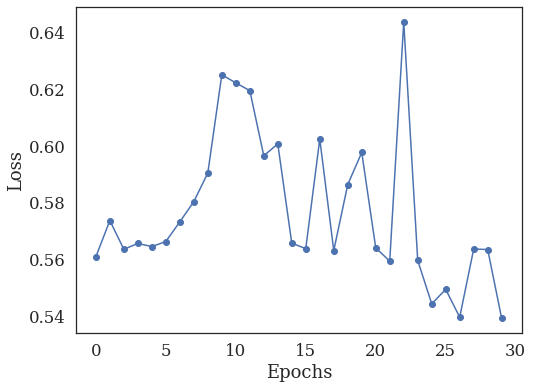

In [ ]:
lstm_clf = LSTM_Pooling_Classifier(label_size=2, vocab_size=None, embedding_dim=100, hidden_dim=128, from_pretrained=True, weights=weights, num_layers=5)
train(lstm_clf, train_loader, val_loader, lr=5e-5, n_epochs=30)

We observe unstable decrease of the loss function and a increase in all the classification metrics.

***Testing***

In [ ]:
tokenized_sentences_test_in = tokenize_sentence(sentences_test_in, tokenizer)
tokenized_sentences_test_out = tokenize_sentence(sentences_test_out, tokenizer)

tokens_id_test_in = encode_sentences(tokenized_sentences_test_in, embedding_model)
tokens_id_test_out = encode_sentences(tokenized_sentences_test_out, embedding_model)

test_in_dataset = TensorDataset(tokens_id_test_in, torch.tensor(labels_test_in))
test_in_loader = DataLoader(test_in_dataset, batch_size = tokens_id_test_in.shape[0])

test_out_dataset = TensorDataset(tokens_id_test_out, torch.tensor(labels_test_out))
test_out_loader = DataLoader(test_out_dataset, batch_size = tokens_id_test_out.shape[0])

In [ ]:
test(lstm_clf, test_in_loader)

Accuracy on test :  0.7001897533206831
F0 score on test : 0.20999999999999996
F1 score on test : 0.8149882903981265
Mattthews Correlation Coeffient on test :  0.14815617827919508
Confusion matrix : [[ 21 141]
 [ 17 348]]


In [ ]:
test(lstm_clf, test_out_loader)

Accuracy on test :  0.6647286821705426
F0 score on test : 0.16425120772946858
F1 score on test : 0.7903030303030303
Mattthews Correlation Coeffient on test :  0.04250816472950028
Confusion matrix : [[ 17 145]
 [ 28 326]]


## B) ELMO Analysis

***Training***

In [ ]:
tokenized_sentences_train = tokenize_sentence(sentences_train, tokenizer)
tokens_id_train = batch_to_ids(tokenized_sentences_train)

sampler_seed = 0

input_train, input_val, labels_training, labels_val = train_test_split(tokens_id_train, labels_train, test_size = 0.2, random_state=sampler_seed)

input_train = torch.tensor(input_train)
labels_training = torch.tensor(labels_training)

train_dataset = TensorDataset(input_train, labels_training)
train_loader = DataLoader(train_dataset, batch_size = batch_size)

input_val = torch.tensor(input_val)
labels_val = torch.tensor(labels_val)

val_dataset = TensorDataset(input_val, labels_val)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch 0 ...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Accuracy at epoch 1 :  0.7025131502045587
F0 score at epoch 1 : 0.0
F1 score at epoch 1 : 0.8252660487469963
Mattthews Correlation Coeffient at epoch 1 :  0.0
Epoch 1 ...
Accuracy at epoch 2 :  0.7025131502045587
F0 score at epoch 2 : 0.0
F1 score at epoch 2 : 0.8252660487469963
Mattthews Correlation Coeffient at epoch 2 :  0.0
Epoch 2 ...
Accuracy at epoch 3 :  0.7025131502045587
F0 score at epoch 3 : 0.0
F1 score at epoch 3 : 0.8252660487469963
Mattthews Correlation Coeffient at epoch 3 :  0.0
Epoch 3 ...
Accuracy at epoch 4 :  0.7030976037405027
F0 score at epoch 4 : 0.011673151750972763
F1 score at epoch 4 : 0.8253094910591472
Mattthews Correlation Coeffient at epoch 4 :  0.03582437574847257
Epoch 4 ...
Accuracy at epoch 5 :  0.7019286966686148
F0 score at epoch 5 : 0.00390625
F1 score at epoch 5 : 0.8247422680412371
Mattthews Correlation Coeffient at epoch 5 :  0.003286261640568855
Epoch 5 ...
Accuracy at epoch 6 :  0.7019286966686148
F0 score at epoch 6 : 0.022988505747126436
F1 

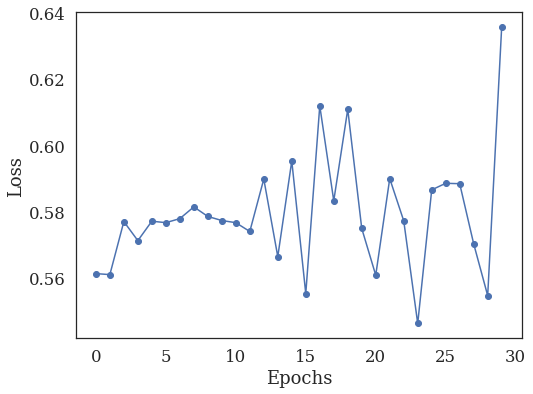

In [ ]:
elmo_clf = ELMOPoolingClassifier(label_size=2, dropout=0.5)

train(elmo_clf, train_loader, val_loader, lr=5e-5, n_epochs=30)

Same as before, we observe an unstable loss decrease at the first epochs and an very unstable statu quo for the last epochs, but an increase in all the classification metrics. Moreover, metrics after convergence are better than LSTM layer.

***Testing***

In [ ]:
tokenized_sentences_test_in = tokenize_sentence(sentences_test_in, tokenizer)
tokens_id_test_in = batch_to_ids(tokenized_sentences_test_in)

tokenized_sentences_test_out = tokenize_sentence(sentences_test_out, tokenizer)
tokens_id_test_out = batch_to_ids(tokenized_sentences_test_out)

test_in_dataset = TensorDataset(tokens_id_test_in, torch.tensor(labels_test_in))
test_in_loader = DataLoader(test_in_dataset, batch_size = tokens_id_test_in.shape[0])

test_out_dataset = TensorDataset(tokens_id_test_out, torch.tensor(labels_test_out))
test_out_loader = DataLoader(test_out_dataset, batch_size = tokens_id_test_out.shape[0])

In [ ]:
test(elmo_clf, test_in_loader)

Accuracy on test :  0.7096774193548387
F0 score on test : 0.4395604395604396
F1 score on test : 0.8040973111395646
Mattthews Correlation Coeffient on test :  0.26099884887399366
Confusion matrix : [[ 60 102]
 [ 51 314]]


In [ ]:
test(elmo_clf, test_out_loader)

Accuracy on test :  0.6666666666666666
F0 score on test : 0.34351145038167935
F1 score on test : 0.7766233766233765
Mattthews Correlation Coeffient on test :  0.14372466615378499
Confusion matrix : [[ 45 117]
 [ 55 299]]


## C) Bert Analysis

***Specific function for Bert preprocessing***

In [ ]:
def get_bert_input(sentences, bert_tokenizer):
  pad_length = 64
  tokens_id = []
  attention_masks = []

  for sentence in sentences:
    tokens_id.append(bert_tokenizer.encode(sentence, padding='max_length', add_special_tokens=True,
                                            max_length=pad_length))
  for id_list in tokens_id:
    attention_masks.append([int(id > 0) for id in id_list])

  return torch.tensor(tokens_id), torch.tensor(attention_masks)

***Finetuning***

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding_side = 'right')
tokens_id_train, attention_masks_train = get_bert_input(sentences_train, bert_tokenizer)

In [ ]:
sampler_seed = 42
input_train, input_val, labels_training, labels_val = train_test_split(tokens_id_train, labels_train, test_size = 0.2, random_state = sampler_seed)
attention_masks_training, attention_masks_val = train_test_split(attention_masks_train, test_size = 0.2, random_state = sampler_seed)

input_train = torch.tensor(input_train)
attention_masks_training = torch.tensor(attention_masks_training)
labels_training = torch.tensor(labels_training)

train_dataset = TensorDataset(input_train, attention_masks_training, labels_training)
train_loader = DataLoader(train_dataset, batch_size = 32)

input_val = torch.tensor(input_val)
attention_masks_val= torch.tensor(attention_masks_val)
labels_val = torch.tensor(labels_val)

val_dataset = TensorDataset(input_val, attention_masks_val, labels_val)
val_loader = DataLoader(val_dataset, batch_size = 32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 0 ...
Accuracy at epoch 1 :  0.81531268264173
F0 score at epoch 1 : 0.6609442060085837
F1 score at epoch 1 : 0.8730923694779116
Mattthews Correlation Coeffient at epoch 1 :  0.5354167296189711
Epoch 1 ...
Accuracy at epoch 2 :  0.8024547048509644
F0 score at epoch 2 : 0.6529774127310062
F1 score at epoch 2 : 0.8619281045751634
Mattthews Correlation Coeffient at epoch 2 :  0.5149055173061695
Epoch 2 ...
Accuracy at epoch 3 :  0.8012857977790766
F0 score at epoch 3 : 0.6755725190839695
F1 score at epoch 3 : 0.8567818028643639
Mattthews Correlation Coeffient at epoch 3 :  0.5361534798220444
Epoch 3 ...
Accuracy at epoch 4 :  0.8176504967855055
F0 score at epoch 4 : 0.6578947368421052
F1 score at epoch 4 : 0.8756972111553786
Mattthews Correlation Coeffient at epoch 4 :  0.5366761596063085
Epoch 4 ...
Accuracy at epoch 5 :  0.8129748684979544
F0 score at epoch 5 : 0.6380090497737557
F1 score at epoch 5 : 0.8739164696611506
Mattthews Correlation Coeffient at epoch 5 :  0.51855472553784

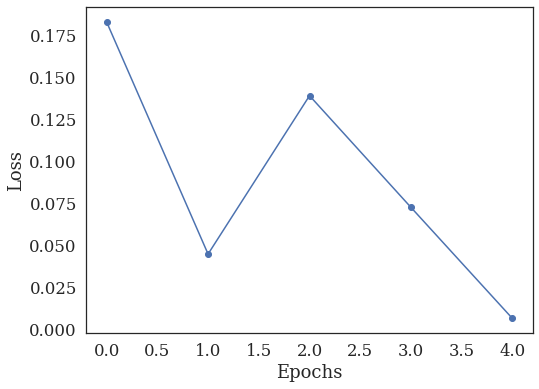

In [ ]:
bert_clf = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2, output_hidden_states = False)
train(bert_clf, train_loader, val_loader, lr=5e-5, n_epochs=5)

We observe that BERT model outperforms largely other model for all classification metrics after very few epochs.

***Testing***

In [ ]:
tokens_id_test_in, attention_masks_test_in = get_bert_input(sentences_test_in, bert_tokenizer)

test_in_dataset = TensorDataset(tokens_id_test_in, attention_masks_test_in, torch.tensor(labels_test_in))
test_in_loader = DataLoader(test_in_dataset, batch_size = tokens_id_test_in.shape[0])

tokens_id_test_out, attention_masks_test_out = get_bert_input(sentences_test_out, bert_tokenizer)

test_out_dataset = TensorDataset(tokens_id_test_out, attention_masks_test_out, torch.tensor(labels_test_out))
test_out_loader = DataLoader(test_out_dataset, batch_size = tokens_id_test_out.shape[0])

In domain dataset

In [ ]:
test(bert_clf, test_in_loader)

Accuracy on test :  0.8406072106261859
F0 score on test : 0.7103448275862069
F1 score on test : 0.8900523560209425
Mattthews Correlation Coeffient on test :  0.6104251576640887
Confusion matrix : [[103  59]
 [ 25 340]]


Out of domain dataset

In [ ]:
test(bert_clf, test_out_loader)

Accuracy on test :  0.7965116279069767
F0 score on test : 0.6067415730337079
F1 score on test : 0.8627450980392158
Mattthews Correlation Coeffient on test :  0.49823214802436
Confusion matrix : [[ 81  81]
 [ 24 330]]


# 5) Qualitative analysis

## A) Analysis of BERT's results

Now, we will analyze the BERT results. We try to understand where BERT makes mistakes.

To do so, we will look at the cases when the BERT mislabelled some sentences.

In [ ]:
def get_prediction(text_list, bert_clf):
    # prepare our text into tokenized sequence
    #inputs = bert_tokenizer(text, padding=True, truncation=True, max_length=64, return_tensors="pt").to(device)
    input, attention_mask = get_bert_input(text_list, bert_tokenizer)
    # perform bert_clf to our model
    output = bert_clf(input.to(device), attention_mask.to(device))
    label_out = torch.argmax(output[0], axis = 1).to('cpu').numpy()
    
    return label_out[0]

In [ ]:
df_test = df_test_in.append(df_test_out).reset_index()

In [ ]:
res = df_test.copy()
res['pred_bert'] = [get_prediction([res.sentence[i]], bert_clf) for i in range(len(res))]
good_pred = res[res['label'] == res['pred_bert']].reset_index(drop=True)
true_pos = res[(res['label']==1) & (res['pred_bert']==1)].reset_index(drop=True)
true_neg = res[(res['label']==0) & (res['pred_bert']==0)].reset_index(drop=True)
false_neg = res[(res['label']==1) & (res['pred_bert']==0)].reset_index(drop=True)
false_pos = res[(res['label']==0) & (res['pred_bert']==1)].reset_index(drop=True)

We analyse number of words considering all type of predictions (True/False positive, True/False negative).

In [ ]:
good_pred_txt = " ".join(good_pred.sentence)
print('Average number of words for good prediction sentences : ', len(good_pred_txt.split(" "))/len(good_pred))

Average number of words for good prediction sentences :  7.621266427718041


In [ ]:
true_pos_txt = " ".join(true_pos.sentence)
len(true_pos_txt.split(" "))/len(true_pos)

print('Average number of words for True positive sentences : ', len(true_pos_txt.split(" "))/len(true_pos))

Average number of words for True positive sentences :  7.855769230769231


In [ ]:
true_neg_txt = " ".join(true_neg.sentence)
len(true_neg_txt.split(" "))/len(true_neg)

print('Average number of words for True negative sentences : ', len(true_neg_txt.split(" "))/len(true_neg))

Average number of words for True negative sentences :  6.934272300469484


In [ ]:
false_pos_txt = " ".join(false_pos.sentence)

print('Average number of words for False positive sentences : ', len(false_pos_txt.split(" "))/len(false_pos))

Average number of words for False positive sentences :  9.567567567567568


In [ ]:
false_neg_txt = " ".join(false_neg.sentence)

print('Average number of words for False negative sentences : ', len(false_neg_txt.split(" "))/len(false_neg))

Average number of words for False negative sentences :  8.642105263157895


We can see that short sentences are prominent in wrong predicted sentences.

We will use Part Of Speech taggins to understand in what kind of sentence the BERT struggles to classify correctly.

5699


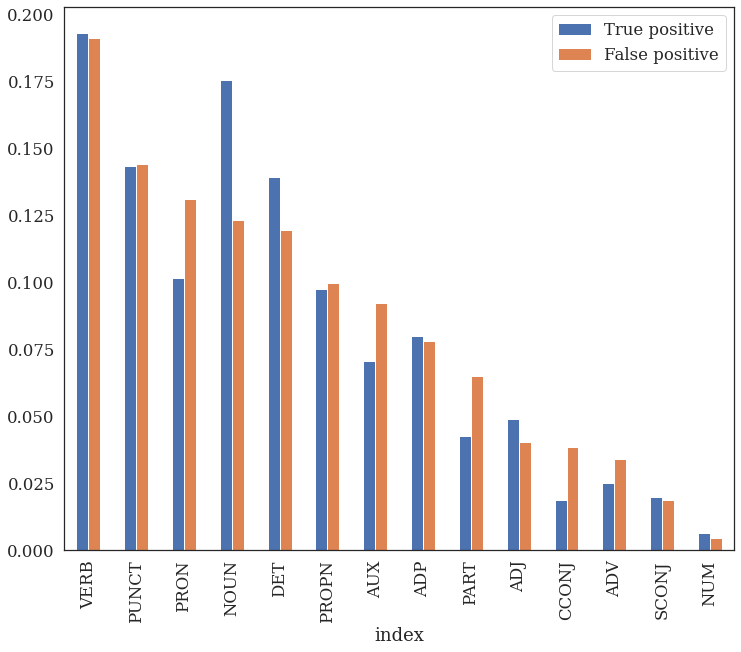

In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

# We apply POS on the false positive sentences and on the well-labelled sentences.

nlp = spacy.load("en_core_web_sm")
false_pos_txt = " ".join(false_pos.sentence)
article = nlp(false_pos_txt)
labels_false_pos = [x.pos_ for x in article]


d_false_pos = Counter(labels_false_pos)

#We consider the percentiles of word types
df_count_false = pd.DataFrame.from_dict(d_false_pos, orient='index').reset_index()
df_count_false['False positive'] = (df_count_false[0]/len(false_pos_txt.split(" ")))
df_count_false = df_count_false.sort_values(by='False positive',ascending=False)


true_pos_txt = " ".join(true_pos.sentence)
article = nlp(true_pos_txt)
labels_true_pos = [x.pos_ for x in article]
print(len(labels_true_pos))


d_true_pos = Counter(labels_true_pos)

df_count_true = pd.DataFrame.from_dict(d_true_pos, orient='index').reset_index()


#We consider the percentiles of word types
df_count_true['True positive'] = (df_count_true[0]/len(true_pos_txt.split(" ")))
df_count_true = df_count_true.sort_values(by='True positive',ascending=False)

df_comparison = df_count_false.merge(df_count_true, on='index')
df_comparison = df_comparison[['index','False positive','True positive']]

# We represent
sns.set(rc={'figure.figsize':(12,10)}, style='white', font_scale=1.5, font='serif')
df_hist = pd.DataFrame({'True positive': df_comparison['True positive'].astype('float32').values,
                   'False positive': df_comparison['False positive'].astype('float32').values}, index=df_comparison['index'])
df_hist.plot.bar(rot=90)
plt.show()

This plot represents the proportion of each kind of word either in the sentences mislabelled (False_positive) or in the sentences well labelled (True_positive).

From this graph we can draw three main results:
*   There are way more pronouns (PRON) in the False_positive sentences than in the True_positive sentences. Indeed, English language has a lot of complex pronouns that could be difficult to handle, especially when it comes to pronouns related to verbs. A case in point might be "look at" VS "look up to" in which the pronouns change a lot the meaning of the verb.
*   There are way more Proper name (PROPN) in the False_positive sentences than in the True_positive sentences. It can also be a reason of the mislabelled sentences because Proper name might be sometimes seen as a nouns if they don't have capital letters which can cause a mislabelling.
*   There are way more nouns (NOUN) in the True_positive sentences than in the False_positive sentences. Indeed, a mistake from a mispelled noun is easier to catch than a grammatical mistake for instance. Thus it comes as no surprise that the BERT struggles to find the mistakes in sentences with few nouns.

1723


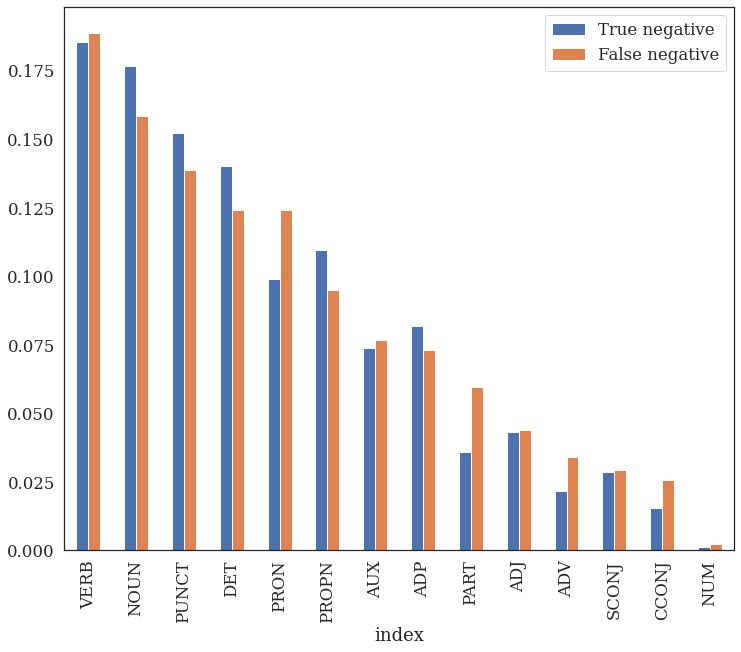

In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

# We apply POS on the false positive sentences and on the well-labelled sentences.

nlp = spacy.load("en_core_web_sm")
false_neg_txt = " ".join(false_neg.sentence)
article = nlp(false_neg_txt)
labels_false_neg = [x.pos_ for x in article]


d_false_neg = Counter(labels_false_neg)

#We consider the number of word types per phrases
df_count_false = pd.DataFrame.from_dict(d_false_neg, orient='index').reset_index()
df_count_false['False negative'] = (df_count_false[0]/len(false_neg_txt.split(" ")))
df_count_false = df_count_false.sort_values(by='False negative',ascending=False)


true_neg_txt = " ".join(true_neg.sentence)
article = nlp(true_neg_txt)
labels_true_neg = [x.pos_ for x in article]
print(len(labels_true_neg))


d_true_neg = Counter(labels_true_neg)

df_count_true = pd.DataFrame.from_dict(d_true_neg, orient='index').reset_index()

#We consider the number of word types per phrases
df_count_true['True negative'] = (df_count_true[0]/len(true_neg_txt.split(" ")))
df_count_true = df_count_true.sort_values(by='True negative',ascending=False)

df_comparison = df_count_false.merge(df_count_true, on='index')
#df_comparison = df_comparison.rename({'index' : 'Word Type'})
df_comparison = df_comparison[['index','False negative','True negative']]

# We represent
sns.set(rc={'figure.figsize':(12,10)}, style='white', font_scale=1.5, font='serif')
df_hist = pd.DataFrame({'True negative': df_comparison['True negative'].astype('float32').values,
                   'False negative': df_comparison['False negative'].astype('float32').values}, index=df_comparison['index'])
df_hist.plot.bar(rot=90)
plt.show()

This plot represents the proportion of each kind of word either in the sentences mislabelled (False_negative) or in the sentences well labelled (True_negative).

From this graph we can draw the following explanations:
*   There are way more pronouns (PRON) in the False_negative sentences than in the True_negative sentences. As explained before, pronounx in English are complex to handle. What's tricky in those cases is that pronouns mistakes are not caused by mispellings but only by a wrong arrangement of the pronouns with the words they are reflecting to.
*   There are way more particle words (PART) in the False_negative sentences than in the True_negative sentences. For being a very peculiar concept, BERT classifier struggles to classify correctly sentences in which there is a lot of particle. Indeed, particles are function words that must be associated with another word or phrase to impart meaning and that do not satisfy definitions of other universal parts of speech (e.g. adpositions, coordinating conjunctions, subordinating conjunctions or auxiliary verbs). It is a very contextual type of word which is still, relatively well managed by BERT, regarding the complexity of this kind of task.


Let's look at some examples of misclassification.
Using Spacy's displacy module, we look at the dependency visualizer, dep, shows part-of-speech tags and syntactic dependencies.

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc=nlp(false_pos.sentence[12])
displacy.render(doc, style='dep',jupyter=True)

In this case, we can clearly see that the mistake is "at it" which should be "there" instead. Still, "to live at" is correct but "to live at it" is not which might explain why BERT classified this sentence as positive. 

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(false_neg.sentence[32])
displacy.render(doc, style='dep',jupyter=True)

This sentence is tricky because it includes an indirect question. The part "was Alison..." might be the part that BERT classified as incorrect.